# Init

In [1]:
using LinearAlgebra
using NearestNeighbors
using StaticArrays
using Luxor
using DataStructures
include("utils.jl"   )
include("kernels.jl" );

# Problem Domain

In [2]:
_DIM_X    = 4
_DIM_A    = 1
Fmax      = 10.0 #7.5 #15.0 #25.0 #5.0 #10.0 #20.0
Fdiv      = 4.0 #8.0 # 4.0
_X_DOMAIN = [ -30.0 +30.0 ; # thetaDotDot
              -15.0 +15.0 ; # thetaDot
              -20.0 +20.0 ; # theta
              -10.0 +10.0 ] # xDot
_A_DOMAIN = [ -Fmax +Fmax ]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10;

nX = _DIM_X; # ---- State    dims
nA = _DIM_A; # ---- Action   dims
nQ = nX + nA; # --- Combined dims
X  = zeros( nX ); # Current position
A  = zeros( nA ); # Current effort
Q  = zeros( nQ ); # Current Q state

include("env_cartpole.jl");

# Q-Learning Helpers

In [3]:
"""
Assemble <State,Action> into Q-state
"""
function get_Q( X, A )
    res = zeros( nQ );
    res[ 1:nX ] = X[:];
    if typeof( A ) == Float64
        res[ nX+1 ] = A;
    else
        res[ nX+1:nQ ] = A;
    end
    return res;
end


"""
Disassemble <State,Action> into Q-state
"""
function XA_from_Q( Q )
    return Q[ 1:nX ], Q[ nX+1:nQ ];
end

"""
Select the relvant variables from the state vector
"""
function select_X_vector( Xbig )
    return [ Xbig[1], Xbig[2], Xbig[3], Xbig[5] ]
end

"""
Normalize `theta` to shortest angle to zero
"""
function norm_turn( theta )
    thetaN = abs( theta % (2*pi) )
    if thetaN > pi
        thetaN = (2*pi) - thetaN
    end
    return thetaN
end


"""
Reward high speed at the bottom and low speed at the top
"""
function cartpole_reward( X )
    
    # 0. Set limits
    maxThetaDot =  10.0
    maxX        =   2.0
    # 1. Set weights
    thFactor    = 100.0
    thDotFactor =   8.0
    
    # 2. Unpack & Normalize state
    thetaDotN   = abs( X[2] ) # ----- Angular velocity
    thetaN      = X[3] # Angle
    xN          = abs( X[6] ) # ----- Fulcrum position
    # 3. Reward high speed at the bottom and low speed at the top
    R = thFactor*cos(thetaN) - thDotFactor*cos(thetaN)*(thetaDotN)
    
    
    if xN > maxX
        R -= xN
    end
    return R
end

"""
Return the indices and scores of all the peak rewards in the data
"""
function find_state_history_R_peaks( X_hist, N_pks )
    
    epLen   = size( X_hist, 2 )
    rising  = false
    lastVal = 1e9
    lastRis = false
    pqPeaks = PriorityQueue();
    rtnPeak = []
    
    for j = 1:epLen
        X       = X_hist[:,j]
        currVal = cartpole_reward( X )
        rising  = (currVal > lastVal)
        if (!rising) && lastRis
            pqPeaks[j] = -currVal # Store the current index at its current (negative) value
        end
        lastVal = currVal
        lastRis = rising
    end
    for i = 1:min( N_pks, length( pqPeaks ) )
        append!( rtnPeak, dequeue!( pqPeaks ) )
    end
    
    return rtnPeak;
end


"""
Given a state `X`, determine the best action
"""
function optimal_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   = 0.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = cartpole_reward( Xp )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_fuzzy( 
            Q_kdTree, G, V, 
            get_Q( 
                select_X_vector( Xp ), 
                A 
            ); 
            k = vNN 
        )
        if (Ra != 0.0) && (Ra > bestR)
            bestR = Ra
            bestA = A
        end
    end
    # println( bestR )
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state_exp( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    # println( testPts )
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_fuzzy_exp( 
            Q_kdTree, G, V, 
            get_Q( 
                select_X_vector( Xp ), 
                A 
            ); 
            k = vNN 
        )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    # println( bestR )
    return bestA
end


"""
Return number of seconds that penulum was within double-sided `angleMargin` of vertical
"""
function vertical_score_s( stateHistory, angleMargin, ts )
    angles = stateHistory[3,:]
    N      = length( angles )
    score  = 0.0
    # println( "vertical_score_s: Analize series of ", N, " timesteps." )
    for j = 1:N
        if abs( angles[j] ) <= angleMargin
            score += ts
        end
    end
    return score
end;

# Q-Function Hacks

In [4]:
"""
Blend two vectors by element
"""
function blend_alpha_of_A_into_B( alpha, A, B )
    return A*alpha + B*(1.0 - alpha)
end


"""
Exchange nonzero values
"""
function exchange_nonzeros( A, B )
    rtnA = zeros( size(A, 1) )    
    rtnB = zeros( size(B, 1) )
    N    = size(A, 1)
    for j = 1:N
        
        # Handle A
        if A[j] == 0.0
            rtnA[j] = B[j]
        else
            rtnA[j] = A[j]
        end
        
        # Handle B
        if B[j] == 0.0
            rtnB[j] = A[j]
        else
            rtnB[j] = B[j]
        end
    end
    
    return rtnA, rtnB
end;

# CartPole Environment Parameters

In [5]:
dur_s     = 40
ts        = 0.01

0.01

# Agent Data Structs

In [6]:
Fres     = Fmax/Fdiv
spaceDiv = 4.0 # 1.0 # 2.0 # 5.0 # 7.5  

### Construct grid of anchors ###
G    = regular_grid_pts_nD( _Q_DOMAIN, [ spaceDiv, spaceDiv, spaceDiv, spaceDiv, Fres ] );
nPts = size( G )[2]; # ------- Number of anchors
mDim = size( G )[1]; # ------- Dimensionality of anchors 
V    = zeros(Float64, nPts); # Values at anchors
VS   = zeros(Float64, nPts); # Scratch values
vsts = zeros(Int64, nPts); # - Set number of visits to zero
println( size( G ) )

# Construct spatial trees over anchors (WITHOUT reordering!)
Q_kdTree = KDTree( G            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
X_kdTree = KDTree( G[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
Q_blTree = BallTree( G             ); 
X_blTree = BallTree( G[1:_DIM_X,:] ); 

(5, 76032)


In [7]:
T       = Int64((1/ts)*dur_s)
N_0     = N_cart( 0.0, 0.0, pi/2.0 )
X_0     = [ 0.0, 0.0, pi, 0.0, 0.0, 10.0 , N_0 ]
states  = zeros( size( X_0, 1 ), T )
actions = zeros( T );
bestXs  = zeros( size( X_0, 1 ), T )
bestAs  = zeros( T );

In [8]:
vSwp = zeros(Float64, nPts); # Swap values
vBst = zeros(Float64, nPts); # Best values
vBAv = zeros(Float64, nPts); # Values for best average
vBlA = zeros(Float64, nPts); # Values for best average
vAll = zeros(Float64, nPts); # Absorbs all training

In [9]:
vB25 = zeros(Float64, nPts); # Best 25 : Train 75
vB50 = zeros(Float64, nPts); # Best 50 : Train 50
vB75 = zeros(Float64, nPts); # Best 75 : Train 25
vB90 = zeros(Float64, nPts); # Best 90 : Train 10
vB95 = zeros(Float64, nPts); # Best 95 : Train  5

# Agent Hyperparameters

In [10]:
##### Q(TD)-Learning Params #####
scale = 7.5; #1.650; # ----------- scale
vNN   =  4 #10 #4 #6 #3 # Value nearest neighbors
bNN   =  1; #1 # Blend nearest neighbors

@assert Fres < scale "!! `scale` SET TOO LOW !!"

alpha    = 0.02148 # 0.99 # 0.75 # 0.5 # 0.25 # 0.125 # 0.0625 # 0.03125 # 0.015625 # 0.00782 # 0.00391
gamma    = 0.999
swapDiv  = 1
epsMin   = 0.00 # Last iter is policy eval
epsMax   = 0.50 #0.50 #0.15 #0.50 # 0.3 # 0.75 # 1.00
episodes =  64 # 32 #64 #2048 #1024 #128 #512 #256 #20 # 160 # 40 # 80
epochs   =  32 #128 #64 # 32 #16
EXPrand  = 1.00 #0.25 #0.5 # 0.75
Alpha    = 0.875
aMargin  = (pi/180)*15.0;

##### Q-Function Hacks #####
beta   = 0.15
blSode = false
blPoch = false

##### Eligibility Params #####
useElig = false
N_peaks =  40
N_steps = 200
lambda  =   0.95

0.95

# Training


Epoch 1, Best Score: -100.0
Training Iteration 4 score: 0.0, epsilon: 0.4765625
Training Iteration 8 score: 0.0, epsilon: 0.4453125
Training Iteration 12 score: 0.0, epsilon: 0.4140625
Training Iteration 16 score: 0.13999999999999999, epsilon: 0.3828125
Training Iteration 20 score: 0.0, epsilon: 0.3515625
Training Iteration 24 score: 0.0, epsilon: 0.3203125
Training Iteration 28 score: 0.0, epsilon: 0.2890625
Training Iteration 32 score: 0.18000000000000002, epsilon: 0.2578125
Training Iteration 36 score: 0.0, epsilon: 0.2265625
Training Iteration 40 score: 0.0, epsilon: 0.1953125
Training Iteration 44 score: 0.0, epsilon: 0.1640625
Training Iteration 48 score: 0.0, epsilon: 0.1328125
Training Iteration 52 score: 0.0, epsilon: 0.1015625
Training Iteration 56 score: 0.0, epsilon: 0.0703125
Training Iteration 60 score: 0.0, epsilon: 0.0390625
Training Iteration 64 score: 0.0, epsilon: 0.0078125
Average Score: 0.09187500000000007

Epoch 2, Best Score: 0.9900000000000007
Training Iteratio

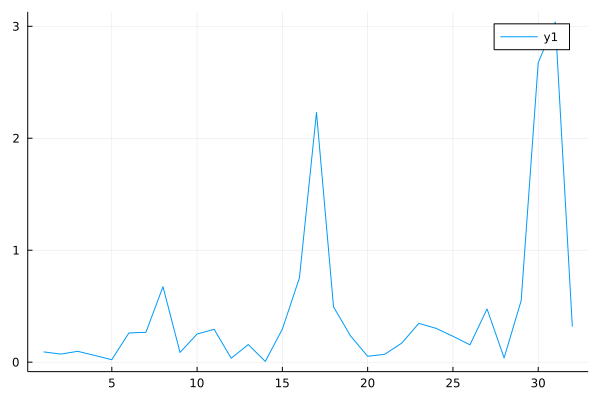

In [11]:
bgn       = time()
averages  = []
bestScore = -100.0;
bestAvg   = -100.0;


for m = 1:epochs
    
    if blSode
        println( "\nEpoch ", m, ", Best Score: ", bestScore )
    elseif blPoch
        println( "\nEpoch ", m, ", Best Score: ", bestScore, ", Best Average: ", bestAvg )
    else
        println( "\nEpoch ", m, ", Best Score: ", bestScore )
    end
    
    
    epsilon = epsMax 
    deltaEp = (epsMax - epsMin)/episodes
    s_Prev  = 0.0
    s_Totl  = 0.0
    
    for l = 1:episodes
        X  = X_0
        
        ##### Double Q-Learning ###########################################

        for k = 1:T

            # 1. Choose action
            if rand() < epsilon
                if rand() < EXPrand 
                    A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                else
                    A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                end
            else

                A = learned_action_for_state( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                if A == 1000.0 # Indicates no values in this region
                    if rand() < EXPrand 
                        A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                    else
                        A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                    end
                end
            end

            # 2. Cache last state
            qLast = get_Q( select_X_vector( X ), A )

            # 3. Generate the next stae
            Xp = cartpole_dyn( X, A, ts )

            # 4. Collect reward R( s, a, s' )
            R_t = cartpole_reward( Xp )

            # 5. Get the optimal action at the next state
            a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fres ], ts )

            # 6. Compute the value at the next state

            V_tp1_opt = query_value_fuzzy( 
                Q_kdTree, G, V, 
                get_Q( 
                    select_X_vector( Xp ), 
                    a_tp1_opt 
                ); 
                k = vNN 
            )
            if isnan( V_tp1_opt )
                V_tp1_opt = 0.0
            end


            # 7. Blend the value back into nearest points

            idxs, wgts = query_contrib_to_neighbors( Q_kdTree, G, V, qLast; k = bNN )

            nNear      = size( idxs, 1 )
            for i = 1:nNear
                j    = idxs[i]
                if !isnan( wgts[i] ) 

                    # VS[j] = R_t + gamma * V_tp1_opt # Q-Learning
                    VS[j] = VS[j] + alpha*( R_t + gamma*V_tp1_opt - V[j] ) # Q(TD)-Learning
                    
                end
            end

            states[:,k] = Xp
            actions[k]  = A

            X = Xp
        end

        s_l    = vertical_score_s( states, aMargin, ts )
        s_Totl += s_l
    
        if s_l > bestScore
            bestScore = s_l
            bestXs    = copy( states  )
            bestAs    = copy( actions )
            vBst      = copy( V )
        end
        
        if l%4 == 0
            println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        end
        
        ##### Eligibility Traces ##########################################
        if useElig
        
            # 1. Find `N_peaks`
            peakDices = find_state_history_R_peaks( states, N_peaks )
            # 2. For each peak, iterate back in time through states
            for ii = 1:min(N_peaks, length(peakDices))
                topDex = peakDices[ ii ]
                X      = states[:,topDex]
                R_jj    = cartpole_reward( X )
                # 3. For each Q-state in the trace
                for jj = (topDex-1):-1:max(1,topDex-N_steps)
                    X = states[:,jj]
                    R_jj *= lambda
                    a_jj = actions[jj]
                    q_jj = get_Q( select_X_vector( X ), a_jj )
                    V_jj = query_value_fuzzy( Q_kdTree, G, V, q_jj; k = vNN )

                    idxs, wgts = query_contrib_to_neighbors( Q_kdTree, G, V, q_jj; k = bNN )
                    nNear      = size( idxs, 1 )

                    for kk = 1:nNear
                        ll = idxs[kk]
                        if !isnan( wgts[kk] ) 
                            VS[ll] = VS[ll] + alpha*( R_jj + V_jj - V[ll] ) # Q(TD)-Learning
                        end
                    end
                end
            end
            
        end
        
        # Decay the exploration probability
        epsilon -= deltaEp
        
        
        ##### Double Q-Learning ##########################################
        # Every `swapDiv` episodes, swap Q-functions for Double Q-Learning
        
        if (l % swapDiv == 0)
            
            vSwp = copy( VS   )
            VS   = copy( V    )
            V    = copy( vSwp )
        end
        
    end
    
    s_Avg = s_Totl / episodes
    println( "Average Score: ", s_Avg )
    
    append!( averages, s_Avg )
     
    
    ##### Q-Function Hacks ################################################
    
    # Blend Method 1: Best Episode
    if blSode
        V  = blend_alpha_of_A_into_B( beta, vBst, V  )
        VS = blend_alpha_of_A_into_B( beta, vBst, VS )
    end
    
    # if (s_Avg > bestAvg) && true
    #     println( "BLEND" )
    #     bestAvg = s_Avg
    #     vBAv    = copy( V ) # Try a blend of both next # FIXME: WE NEVER ACTUALLY USE THIS MATRIX!
    #     vBlA    = blend_alpha_of_A_into_B( 0.50, VS, V ) # FIXME: WE NEVER ACTUALLY USE THIS MATRIX!
    # end
        
end

vTrn = copy( V )
println( "Saved a trained Q-table with size ", size( vTrn ), ", After ", (time()-bgn)/60.0, " minutes of training!" )

using Plots

plot( averages )